In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [10]:
context = data.init()
n = 2
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
<meta message track_name name='01 16th Snare\x00' time=0>
<meta message time_signature numerator=4 denominator=4 clocks_per_click=36 notated_32nd_notes_per_beat=8 time=0>
<meta message time_signature numerator=4 denominator=4 clocks_per_click=36 notated_32nd_notes_per_beat=8 time=0>
note_on channel=0 no

In [23]:
n = 3
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, 
    n_polyrythms=1,
    n_channels=midi.N_NOTES,
    multiTrack=multiTrack)

y_train = x_train
x_test = x_train[-10:]
x_train = x_train[:-10]

note 60 [3.86507374]
note 61 [11.86481876]
note 62 [10.37836616]
note 60 [8.79248569]
note 61 [12.52863522]
note 62 [7.17815992]
note 60 [3.8355781]
note 61 [4.24465741]
note 62 [9.80607168]
note_on channel=0 note=61 velocity=127 time=0.04895833333333333
note_on channel=0 note=62 velocity=127 time=0.015625
note_off channel=0 note=61 velocity=127 time=0.005208333333333333
note_on channel=0 note=60 velocity=127 time=0
note_off channel=0 note=62 velocity=127 time=0.014583333333333334
note_off channel=0 note=60 velocity=127 time=0.005208333333333333
note_on channel=0 note=61 velocity=127 time=0.04375
note_off channel=0 note=61 velocity=127 time=0.019791666666666666
note_on channel=0 note=62 velocity=127 time=0.007291666666666667
note_off channel=0 note=62 velocity=127 time=0.019791666666666666
note_on channel=0 note=61 velocity=127 time=0.036458333333333336
note_off channel=0 note=61 velocity=127 time=0.019791666666666666
note_on channel=0 note=62 velocity=127 time=0.019791666666666666
not

In [12]:
x_train.shape

(90, 150, 3)

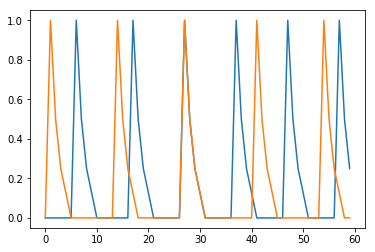

In [16]:
plt.plot(x_train[0,:60,0])
plt.plot(x_train[1,:60,0])

m (30, 3)


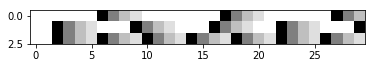

In [14]:
plot.multi(x_train[0, :30])

In [17]:
data = x_train[0,:20]
data.shape

(20, 3)

In [18]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
input_shape

(150, 3)

In [19]:
output_shape

(150, 3)

In [20]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [21]:
input_shape
# input_shape = (150,)
input_shape

(150, 3)

In [22]:
batch_size = 32
original_dim = 150
latent_dim = 50
intermediate_dim = 150
epsilon_std = 1.0

In [15]:
# TODO Batch Normalization

In [16]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [18]:
k_reg = keras.regularizers.l2(1e-5)
# b_reg = keras.regularizers.l1(0.01)
a_reg = keras.regularizers.l1(1e-5)

def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    h = encoder_input
    # image_data_format = 'channels_last'   -   e.g. (28,28,3)
    # naive assumption:
    #   for drumkits no correlation between note_indices and occurrence at an timestep is assumed
    #   (that is, p(E|C) is not significantly different from p(D|C))
    #   - note that this _is_ the case for e.g. HH vs. OH
    #     these often occur in the same register (between different drumkits)
    #   - even with melodic/harmonic data, this assumption could help by reducing
    #    (1) unwanted repetition (stuttering) of notes
    #    (2) unwanted dissonance (caused by playing notes with an interval of a half step)
    
    timesteps = input_shape[-2]
    notes = input_shape[-1]
    
    # Convolve & Pool
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)

    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
    
#     h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
#     # 128 512

    # Dense layers
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
#     h = Dense(intermediate_dim, activation='relu')(h)
#     h = Dense(intermediate_dim, activation='relu')(h)    
#     h = Dropout(0.1)(h) # uncomment when using larger batches
#     h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
    
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, output_shape, filters = 32):
    z_input = Input(shape=(latent_dim,), name='decoder_input-')
    h = z_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    
    timesteps = output_shape[-2] # cols
    notes = output_shape[-1] # rows
    channels = 1 # rgb

    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    m = 4 # multiplier for dims
    output_shape = (channels, notes * m, timesteps)
    p = 'valid'

    # upsampling
    h = Dense(np.prod(output_shape[-3:]), activation='relu')(h)
    h = Reshape(output_shape[-3:])(h)
    
    # Convolve & Pool
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    # TODO
    s1 = (3,1)
    s2 = (1,3)
    s3 = 2
    timesteps_ = int(timesteps / 2)
    h = Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
#     h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)(h)
    h = MaxPooling2D(pool_size=2, strides=2, padding='same')(h)

#     h = Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    h = Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)(h)
    # 'end' of upsampling
    h = Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p)(h)
    dims = keras.backend.int_shape(h)[1:]
    print('dims', dims)
    h = Reshape(dims[0:2])(h)
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    h = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)(h)

    
    # Mean (output)
#     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes)
    h = Flatten()(h)
    h = Dense(np.prod(output_shape), activation='sigmoid')(h)
    output_shape = (timesteps, notes)
    h = Reshape(output_shape)(h)
    decoder_output = h
    model = Model(inputs=z_input, outputs=decoder_output, name='decoder_model-')
    return model

In [19]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, output_shape)


encoder_model.summary()
z_model.summary()
decoder_model.summary()

dims (42, 56, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 75, 32)       96          encoder_input-[0][0]             
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 75, 64)       4160        conv1d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4800)         0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [20]:
vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 50), (None,  739506      encoder_input-[0][0]             
__________________________________________________________________________________________________
z_model- (Model)                (None, 50)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
decoder_model- (Model)          (None, 150, 1)       130482      z_model-[1][0]                   
Total para

In [21]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # img_rows * img_cols
    # xent_loss = K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    xent_loss = K.binary_crossentropy(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)
    return xent_loss + kl_loss

In [22]:
metrics = ['acc','mse','mae','binary_crossentropy']
loss = lambda y_true, y_pred: vae_loss(y_true, y_pred, z_mean, z_log_var)
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [23]:
# vae.add_loss(vae_loss)
# vae.compile(optimizer='rmsprop', metrics=['binary_accuracy','mae'])

In [24]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(260, 150, 1)

In [27]:
# z_train = x_train
# x = np.concatenate([x_train[0:2] for _ in range(1000)])
# x.shape
# x_train = x

In [28]:
epochs = 250
m = int(64*2 * 7/6)
vs = 1/6
shuffle = True
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = vae.fit(x_train[:m], x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks, shuffle=shuffle)
# history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 124 samples, validate on 25 samples
Epoch 1/250
124/124 [==============================] - 1s 5ms/step - loss: 0.7303 - acc: 0.5603 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4991 - binary_crossentropy: 0.6915 - val_loss: 0.6945 - val_acc: 0.4992 - val_mean_squared_error: 0.2505 - val_mean_absolute_error: 0.5000 - val_binary_crossentropy: 0.6941
Epoch 2/250
124/124 [==============================] - 0s 3ms/step - loss: 0.6755 - acc: 0.6152 - mean_squared_error: 0.2411 - mean_absolute_error: 0.4885 - binary_crossentropy: 0.6752 - val_loss: 0.7147 - val_acc: 0.5091 - val_mean_squared_error: 0.2602 - val_mean_absolute_error: 0.4983 - val_binary_crossentropy: 0.7145
Epoch 3/250
124/124 [==============================] - 0s 3ms/step - loss: 0.6586 - acc: 0.6395 - mean_squared_error: 0.2329 - mean_absolute_error: 0.4728 - binary_crossentropy: 0.6585 - val_loss: 0.7592 - val_acc: 0.5168 - val_mean_squared_error: 0.2792 - val_mean_absolute_error: 0.4949 - val_binary_crossen

124/124 [==============================] - 0s 3ms/step - loss: 0.6128 - acc: 0.6501 - mean_squared_error: 0.2020 - mean_absolute_error: 0.4051 - binary_crossentropy: 0.5879 - val_loss: 0.6733 - val_acc: 0.5203 - val_mean_squared_error: 0.2238 - val_mean_absolute_error: 0.4377 - val_binary_crossentropy: 0.6390
Epoch 27/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5958 - acc: 0.6513 - mean_squared_error: 0.1941 - mean_absolute_error: 0.3872 - binary_crossentropy: 0.5694 - val_loss: 0.6865 - val_acc: 0.5221 - val_mean_squared_error: 0.2344 - val_mean_absolute_error: 0.4520 - val_binary_crossentropy: 0.6605
Epoch 28/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5989 - acc: 0.6547 - mean_squared_error: 0.1965 - mean_absolute_error: 0.3957 - binary_crossentropy: 0.5746 - val_loss: 0.7030 - val_acc: 0.5216 - val_mean_squared_error: 0.2360 - val_mean_absolute_error: 0.4374 - val_binary_crossentropy: 0.6728
Epoch 29/250
124/124 [===================

124/124 [==============================] - 0s 3ms/step - loss: 0.5874 - acc: 0.7085 - mean_squared_error: 0.1914 - mean_absolute_error: 0.3872 - binary_crossentropy: 0.5628 - val_loss: 0.6467 - val_acc: 0.6637 - val_mean_squared_error: 0.2167 - val_mean_absolute_error: 0.4251 - val_binary_crossentropy: 0.6240
Epoch 52/250
124/124 [==============================] - 0s 2ms/step - loss: 0.5960 - acc: 0.6938 - mean_squared_error: 0.1938 - mean_absolute_error: 0.3886 - binary_crossentropy: 0.5705 - val_loss: 0.6487 - val_acc: 0.6771 - val_mean_squared_error: 0.2164 - val_mean_absolute_error: 0.4295 - val_binary_crossentropy: 0.6255
Epoch 53/250
124/124 [==============================] - 0s 4ms/step - loss: 0.5907 - acc: 0.7025 - mean_squared_error: 0.1913 - mean_absolute_error: 0.3862 - binary_crossentropy: 0.5662 - val_loss: 0.6556 - val_acc: 0.6237 - val_mean_squared_error: 0.2226 - val_mean_absolute_error: 0.4480 - val_binary_crossentropy: 0.6334
Epoch 54/250
124/124 [===================

124/124 [==============================] - 0s 2ms/step - loss: 0.5897 - acc: 0.7183 - mean_squared_error: 0.1905 - mean_absolute_error: 0.3811 - binary_crossentropy: 0.5625 - val_loss: 0.6304 - val_acc: 0.7053 - val_mean_squared_error: 0.2020 - val_mean_absolute_error: 0.4150 - val_binary_crossentropy: 0.5921
Epoch 77/250
124/124 [==============================] - 0s 2ms/step - loss: 0.5843 - acc: 0.7137 - mean_squared_error: 0.1868 - mean_absolute_error: 0.3796 - binary_crossentropy: 0.5548 - val_loss: 0.6386 - val_acc: 0.6808 - val_mean_squared_error: 0.2058 - val_mean_absolute_error: 0.3997 - val_binary_crossentropy: 0.6006
Epoch 78/250
124/124 [==============================] - 0s 2ms/step - loss: 0.5756 - acc: 0.7173 - mean_squared_error: 0.1843 - mean_absolute_error: 0.3670 - binary_crossentropy: 0.5471 - val_loss: 0.6512 - val_acc: 0.6811 - val_mean_squared_error: 0.2097 - val_mean_absolute_error: 0.4189 - val_binary_crossentropy: 0.6107
Epoch 79/250
124/124 [===================

124/124 [==============================] - 0s 4ms/step - loss: 0.5849 - acc: 0.7237 - mean_squared_error: 0.1868 - mean_absolute_error: 0.3742 - binary_crossentropy: 0.5544 - val_loss: 0.6592 - val_acc: 0.6293 - val_mean_squared_error: 0.2177 - val_mean_absolute_error: 0.4109 - val_binary_crossentropy: 0.6279
Epoch 102/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5770 - acc: 0.7244 - mean_squared_error: 0.1854 - mean_absolute_error: 0.3688 - binary_crossentropy: 0.5505 - val_loss: 0.6688 - val_acc: 0.6555 - val_mean_squared_error: 0.2199 - val_mean_absolute_error: 0.4253 - val_binary_crossentropy: 0.6324
Epoch 103/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5806 - acc: 0.7235 - mean_squared_error: 0.1863 - mean_absolute_error: 0.3715 - binary_crossentropy: 0.5520 - val_loss: 0.6371 - val_acc: 0.6861 - val_mean_squared_error: 0.2098 - val_mean_absolute_error: 0.4080 - val_binary_crossentropy: 0.6084
Epoch 104/250
124/124 [================

124/124 [==============================] - 0s 3ms/step - loss: 0.5762 - acc: 0.7111 - mean_squared_error: 0.1854 - mean_absolute_error: 0.3685 - binary_crossentropy: 0.5497 - val_loss: 0.6449 - val_acc: 0.6981 - val_mean_squared_error: 0.2091 - val_mean_absolute_error: 0.4204 - val_binary_crossentropy: 0.6072
Epoch 127/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5804 - acc: 0.7208 - mean_squared_error: 0.1858 - mean_absolute_error: 0.3781 - binary_crossentropy: 0.5525 - val_loss: 0.6682 - val_acc: 0.6451 - val_mean_squared_error: 0.2212 - val_mean_absolute_error: 0.4146 - val_binary_crossentropy: 0.6355
Epoch 128/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5887 - acc: 0.7196 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3715 - binary_crossentropy: 0.5594 - val_loss: 0.6317 - val_acc: 0.7032 - val_mean_squared_error: 0.2020 - val_mean_absolute_error: 0.3951 - val_binary_crossentropy: 0.5945
Epoch 129/250
124/124 [================

124/124 [==============================] - 1s 5ms/step - loss: 0.5807 - acc: 0.7208 - mean_squared_error: 0.1855 - mean_absolute_error: 0.3708 - binary_crossentropy: 0.5517 - val_loss: 0.6343 - val_acc: 0.7120 - val_mean_squared_error: 0.2061 - val_mean_absolute_error: 0.4282 - val_binary_crossentropy: 0.6014
Epoch 152/250
124/124 [==============================] - 1s 5ms/step - loss: 0.5729 - acc: 0.7247 - mean_squared_error: 0.1836 - mean_absolute_error: 0.3708 - binary_crossentropy: 0.5473 - val_loss: 0.6249 - val_acc: 0.7128 - val_mean_squared_error: 0.2010 - val_mean_absolute_error: 0.4068 - val_binary_crossentropy: 0.5892
Epoch 153/250
124/124 [==============================] - 1s 4ms/step - loss: 0.5660 - acc: 0.7285 - mean_squared_error: 0.1810 - mean_absolute_error: 0.3629 - binary_crossentropy: 0.5399 - val_loss: 0.6351 - val_acc: 0.6669 - val_mean_squared_error: 0.2105 - val_mean_absolute_error: 0.4143 - val_binary_crossentropy: 0.6084
Epoch 154/250
124/124 [================

124/124 [==============================] - 1s 4ms/step - loss: 0.5764 - acc: 0.7238 - mean_squared_error: 0.1852 - mean_absolute_error: 0.3701 - binary_crossentropy: 0.5514 - val_loss: 0.6307 - val_acc: 0.6893 - val_mean_squared_error: 0.2054 - val_mean_absolute_error: 0.3995 - val_binary_crossentropy: 0.5984
Epoch 177/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5785 - acc: 0.7203 - mean_squared_error: 0.1854 - mean_absolute_error: 0.3674 - binary_crossentropy: 0.5513 - val_loss: 0.6316 - val_acc: 0.6760 - val_mean_squared_error: 0.2061 - val_mean_absolute_error: 0.4119 - val_binary_crossentropy: 0.5985
Epoch 178/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5742 - acc: 0.7238 - mean_squared_error: 0.1827 - mean_absolute_error: 0.3655 - binary_crossentropy: 0.5425 - val_loss: 0.6246 - val_acc: 0.7091 - val_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.4057 - val_binary_crossentropy: 0.5889
Epoch 179/250
124/124 [================

124/124 [==============================] - 0s 4ms/step - loss: 0.5718 - acc: 0.7215 - mean_squared_error: 0.1826 - mean_absolute_error: 0.3679 - binary_crossentropy: 0.5435 - val_loss: 0.6507 - val_acc: 0.6893 - val_mean_squared_error: 0.2108 - val_mean_absolute_error: 0.3979 - val_binary_crossentropy: 0.6168
Epoch 202/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5701 - acc: 0.7279 - mean_squared_error: 0.1818 - mean_absolute_error: 0.3613 - binary_crossentropy: 0.5419 - val_loss: 0.6315 - val_acc: 0.6693 - val_mean_squared_error: 0.2069 - val_mean_absolute_error: 0.3981 - val_binary_crossentropy: 0.6017
Epoch 203/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5795 - acc: 0.7317 - mean_squared_error: 0.1851 - mean_absolute_error: 0.3658 - binary_crossentropy: 0.5529 - val_loss: 0.6387 - val_acc: 0.6811 - val_mean_squared_error: 0.2099 - val_mean_absolute_error: 0.4126 - val_binary_crossentropy: 0.6084
Epoch 204/250
124/124 [================

124/124 [==============================] - 0s 3ms/step - loss: 0.5707 - acc: 0.7248 - mean_squared_error: 0.1840 - mean_absolute_error: 0.3671 - binary_crossentropy: 0.5462 - val_loss: 0.6363 - val_acc: 0.6851 - val_mean_squared_error: 0.2079 - val_mean_absolute_error: 0.4005 - val_binary_crossentropy: 0.6032
Epoch 227/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5726 - acc: 0.7280 - mean_squared_error: 0.1824 - mean_absolute_error: 0.3628 - binary_crossentropy: 0.5428 - val_loss: 0.6220 - val_acc: 0.7109 - val_mean_squared_error: 0.2003 - val_mean_absolute_error: 0.4010 - val_binary_crossentropy: 0.5859
Epoch 228/250
124/124 [==============================] - 0s 3ms/step - loss: 0.5730 - acc: 0.7275 - mean_squared_error: 0.1823 - mean_absolute_error: 0.3652 - binary_crossentropy: 0.5450 - val_loss: 0.6411 - val_acc: 0.6933 - val_mean_squared_error: 0.2110 - val_mean_absolute_error: 0.3988 - val_binary_crossentropy: 0.6144
Epoch 229/250
124/124 [================

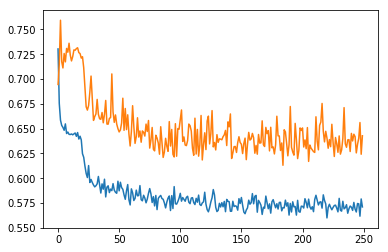

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

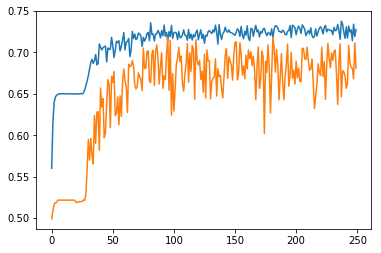

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

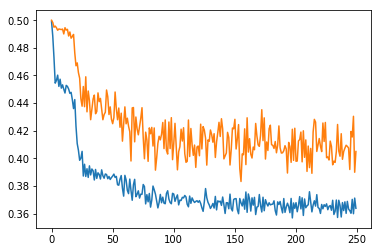

In [31]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [32]:
# plot_model(vae, to_file='model.png')

In [ ]:
plt.plot(x_train[0,:100,:])

In [ ]:
result.shape

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)